# Machine Learning Validation Methods

This notebook demonstrates various validation methods used in machine learning to evaluate model performance and prevent overfitting.

**Author:** AGF and AI Assistant  
**Date:** October, 2025

## Table of Contents

1. [Setup and Data Preparation](#setup)
2. [Hold-out Validation](#holdout)
3. [K-Fold Cross Validation](#kfold)
4. [Leave-One-Out Cross Validation](#loocv)
5. [Leave-P-Out Cross Validation](#lpocv)
6. [Time Series Cross Validation](#timeseries)
7. [Bootstrap Validation](#bootstrap)
8. [Validation Curves](#validation-curves)
9. [Learning Curves](#learning-curves)
10. [Hyperparameter Validation](#hyperparameter)
11. [Nested Cross Validation](#nested)
12. [Comparison of Methods](#comparison)

<a id='setup'></a>
## 1. Setup and Data Preparation

First, let's import all necessary libraries and create sample datasets for our demonstrations.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification, load_iris, fetch_california_housing
from sklearn.model_selection import (
    train_test_split, cross_val_score, KFold, StratifiedKFold,
    TimeSeriesSplit, LeaveOneOut, LeavePOut, ShuffleSplit,
    validation_curve, learning_curve, GridSearchCV, RandomizedSearchCV
)
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set random state for reproducibility
RANDOM_STATE = 42

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

In [2]:
def create_sample_data():
    """Create sample datasets for demonstration"""
    print("Creating sample datasets...")
    
    # Classification dataset
    X_class, y_class = make_classification(
        n_samples=1000, n_features=20, n_informative=15, 
        n_redundant=5, n_clusters_per_class=1, random_state=RANDOM_STATE
    )
    
    # Regression dataset using California housing dataset
    try:
        housing = fetch_california_housing()
        X_reg, y_reg = housing.data[:1000], housing.target[:1000]
        print("Using California housing dataset for regression examples")
    except Exception as e:
        print(f"Could not load California housing dataset: {e}")
        # Fallback to synthetic regression data
        from sklearn.datasets import make_regression
        X_reg, y_reg = make_regression(
            n_samples=1000, n_features=10, noise=0.1, random_state=RANDOM_STATE
        )
        print("Using synthetic regression dataset")
    
    return X_class, y_class, X_reg, y_reg

# Create sample data
X_class, y_class, X_reg, y_reg = create_sample_data()

print(f"Classification dataset shape: {X_class.shape}")
print(f"Regression dataset shape: {X_reg.shape}")
print(f"Classification target distribution: {np.bincount(y_class)}")

Creating sample datasets...
Using California housing dataset for regression examples
Classification dataset shape: (1000, 20)
Regression dataset shape: (1000, 8)
Classification target distribution: [500 500]


<a id='holdout'></a>
## 2. Hold-out Validation (Train-Test Split)

The simplest validation method: split data into training and testing sets.

In [3]:
def holdout_validation(X, y, test_size=0.2):
    """
    Hold-out Validation (Train-Test Split)
    Simple split of data into training and testing sets
    """
    print("HOLD-OUT VALIDATION")
    print("="*50)
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=RANDOM_STATE, stratify=y
    )
    
    print(f"Training set size: {X_train.shape[0]} samples")
    print(f"Test set size: {X_test.shape[0]} samples")
    
    # Train model
    model = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE)
    model.fit(X_train, y_train)
    
    # Evaluate
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    
    print(f"Training Accuracy: {train_score:.4f}")
    print(f"Test Accuracy: {test_score:.4f}")
    print(f"Generalization Gap: {train_score - test_score:.4f}")
    
    return model, train_score, test_score

# Run hold-out validation
model, train_score, test_score = holdout_validation(X_class, y_class)

HOLD-OUT VALIDATION
Training set size: 800 samples
Test set size: 200 samples
Training Accuracy: 1.0000
Test Accuracy: 0.9700
Generalization Gap: 0.0300
Training Accuracy: 1.0000
Test Accuracy: 0.9700
Generalization Gap: 0.0300


<a id='kfold'></a>
## 3. K-Fold Cross Validation

Divides data into k folds, trains on k-1 folds, tests on 1 fold. Includes both regular and stratified versions.

In [4]:
def k_fold_cross_validation(X, y, k=5):
    """
    K-Fold Cross Validation
    Divides data into k folds, trains on k-1 folds, tests on 1 fold
    """
    print("K-FOLD CROSS VALIDATION")
    print("="*50)
    
    model = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE)
    
    # Regular K-Fold
    kfold = KFold(n_splits=k, shuffle=True, random_state=RANDOM_STATE)
    cv_scores = cross_val_score(model, X, y, cv=kfold, scoring='accuracy')
    
    print(f"K-Fold Cross Validation (k={k}):")
    print(f"Individual fold scores: {cv_scores}")
    print(f"Mean CV Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    
    # Stratified K-Fold (maintains class distribution)
    stratified_kfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=RANDOM_STATE)
    stratified_scores = cross_val_score(model, X, y, cv=stratified_kfold, scoring='accuracy')
    
    print(f"\nStratified K-Fold Cross Validation (k={k}):")
    print(f"Individual fold scores: {stratified_scores}")
    print(f"Mean CV Score: {stratified_scores.mean():.4f} (+/- {stratified_scores.std() * 2:.4f})")
    
    return cv_scores, stratified_scores

# Run K-Fold cross validation
cv_scores, stratified_scores = k_fold_cross_validation(X_class, y_class)

K-FOLD CROSS VALIDATION
K-Fold Cross Validation (k=5):
Individual fold scores: [0.98  0.965 0.975 0.99  0.995]
Mean CV Score: 0.9810 (+/- 0.0214)
K-Fold Cross Validation (k=5):
Individual fold scores: [0.98  0.965 0.975 0.99  0.995]
Mean CV Score: 0.9810 (+/- 0.0214)

Stratified K-Fold Cross Validation (k=5):
Individual fold scores: [0.99  0.965 0.955 0.97  0.985]
Mean CV Score: 0.9730 (+/- 0.0258)

Stratified K-Fold Cross Validation (k=5):
Individual fold scores: [0.99  0.965 0.955 0.97  0.985]
Mean CV Score: 0.9730 (+/- 0.0258)


<a id='loocv'></a>
## 4. Leave-One-Out Cross Validation (LOOCV)

Each sample is used once as the test set. Computationally expensive but provides maximum training data.

In [5]:
def leave_one_out_validation(X, y):
    """
    Leave-One-Out Cross Validation (LOOCV)
    Each sample is used once as test set
    """
    print("LEAVE-ONE-OUT CROSS VALIDATION (LOOCV)")
    print("="*50)
    
    # Use smaller subset for LOOCV demo (computationally expensive)
    X_small, y_small = X[:100], y[:100]
    
    model = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
    loo = LeaveOneOut()
    
    loo_scores = cross_val_score(model, X_small, y_small, cv=loo, scoring='accuracy')
    
    print(f"LOOCV on {len(X_small)} samples:")
    print(f"Mean LOOCV Score: {loo_scores.mean():.4f}")
    print(f"Standard Deviation: {loo_scores.std():.4f}")
    print(f"Number of iterations: {len(loo_scores)}")
    
    return loo_scores

# Run LOOCV
loo_scores = leave_one_out_validation(X_class, y_class)

LEAVE-ONE-OUT CROSS VALIDATION (LOOCV)
LOOCV on 100 samples:
Mean LOOCV Score: 0.9400
Standard Deviation: 0.2375
Number of iterations: 100
LOOCV on 100 samples:
Mean LOOCV Score: 0.9400
Standard Deviation: 0.2375
Number of iterations: 100


<a id='lpocv'></a>
## 5. Leave-P-Out Cross Validation

Leave p samples out for testing. More computationally intensive than k-fold but provides more training combinations.

In [6]:
def leave_p_out_validation(X, y, p=2):
    """
    Leave-P-Out Cross Validation
    Leave p samples out for testing
    """
    print(f"LEAVE-P-OUT CROSS VALIDATION (p={p})")
    print("="*50)
    
    # Use smaller subset for LPO demo (computationally expensive)
    X_small, y_small = X[:50], y[:50]
    
    model = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
    lpo = LeavePOut(p=p)
    
    # Only run first 20 iterations for demo (would be too many otherwise)
    lpo_scores = []
    for i, (train_idx, test_idx) in enumerate(lpo.split(X_small)):
        if i >= 20:  # Limit iterations for demo
            break
        X_train_lpo, X_test_lpo = X_small[train_idx], X_small[test_idx]
        y_train_lpo, y_test_lpo = y_small[train_idx], y_small[test_idx]
        
        model.fit(X_train_lpo, y_train_lpo)
        score = model.score(X_test_lpo, y_test_lpo)
        lpo_scores.append(score)
    
    lpo_scores = np.array(lpo_scores)
    print(f"LPO on {len(X_small)} samples (first 20 iterations):")
    print(f"Mean LPO Score: {lpo_scores.mean():.4f}")
    print(f"Standard Deviation: {lpo_scores.std():.4f}")
    
    return lpo_scores

# Run Leave-P-Out validation
lpo_scores = leave_p_out_validation(X_class, y_class)

LEAVE-P-OUT CROSS VALIDATION (p=2)
LPO on 50 samples (first 20 iterations):
Mean LPO Score: 0.9750
Standard Deviation: 0.1090
LPO on 50 samples (first 20 iterations):
Mean LPO Score: 0.9750
Standard Deviation: 0.1090


<a id='timeseries'></a>
## 6. Time Series Cross Validation

Respects temporal order of data - crucial for time series data where future cannot predict the past.

In [7]:
def time_series_validation(n_samples=200):
    """
    Time Series Cross Validation
    Respects temporal order of data
    """
    print("TIME SERIES CROSS VALIDATION")
    print("="*50)
    
    # Create time series-like data
    np.random.seed(RANDOM_STATE)
    time_index = np.arange(n_samples)
    X_ts = np.column_stack([
        time_index,
        np.sin(time_index * 0.1) + np.random.normal(0, 0.1, n_samples),
        np.cos(time_index * 0.05) + np.random.normal(0, 0.1, n_samples)
    ])
    y_ts = (X_ts[:, 1] + X_ts[:, 2] > 0).astype(int)
    
    model = RandomForestClassifier(n_estimators=50, random_state=RANDOM_STATE)
    
    # Time Series Split
    tscv = TimeSeriesSplit(n_splits=5)
    ts_scores = cross_val_score(model, X_ts, y_ts, cv=tscv, scoring='accuracy')
    
    print(f"Time Series Cross Validation:")
    print(f"Individual fold scores: {ts_scores}")
    print(f"Mean TS CV Score: {ts_scores.mean():.4f} (+/- {ts_scores.std() * 2:.4f})")
    
    return ts_scores, X_ts, y_ts, tscv

# Run Time Series validation
ts_scores, X_ts, y_ts, tscv = time_series_validation()

TIME SERIES CROSS VALIDATION
Time Series Cross Validation:
Individual fold scores: [1.         0.33333333 0.63636364 1.         0.87878788]
Mean TS CV Score: 0.7697 (+/- 0.5108)
Time Series Cross Validation:
Individual fold scores: [1.         0.33333333 0.63636364 1.         0.87878788]
Mean TS CV Score: 0.7697 (+/- 0.5108)


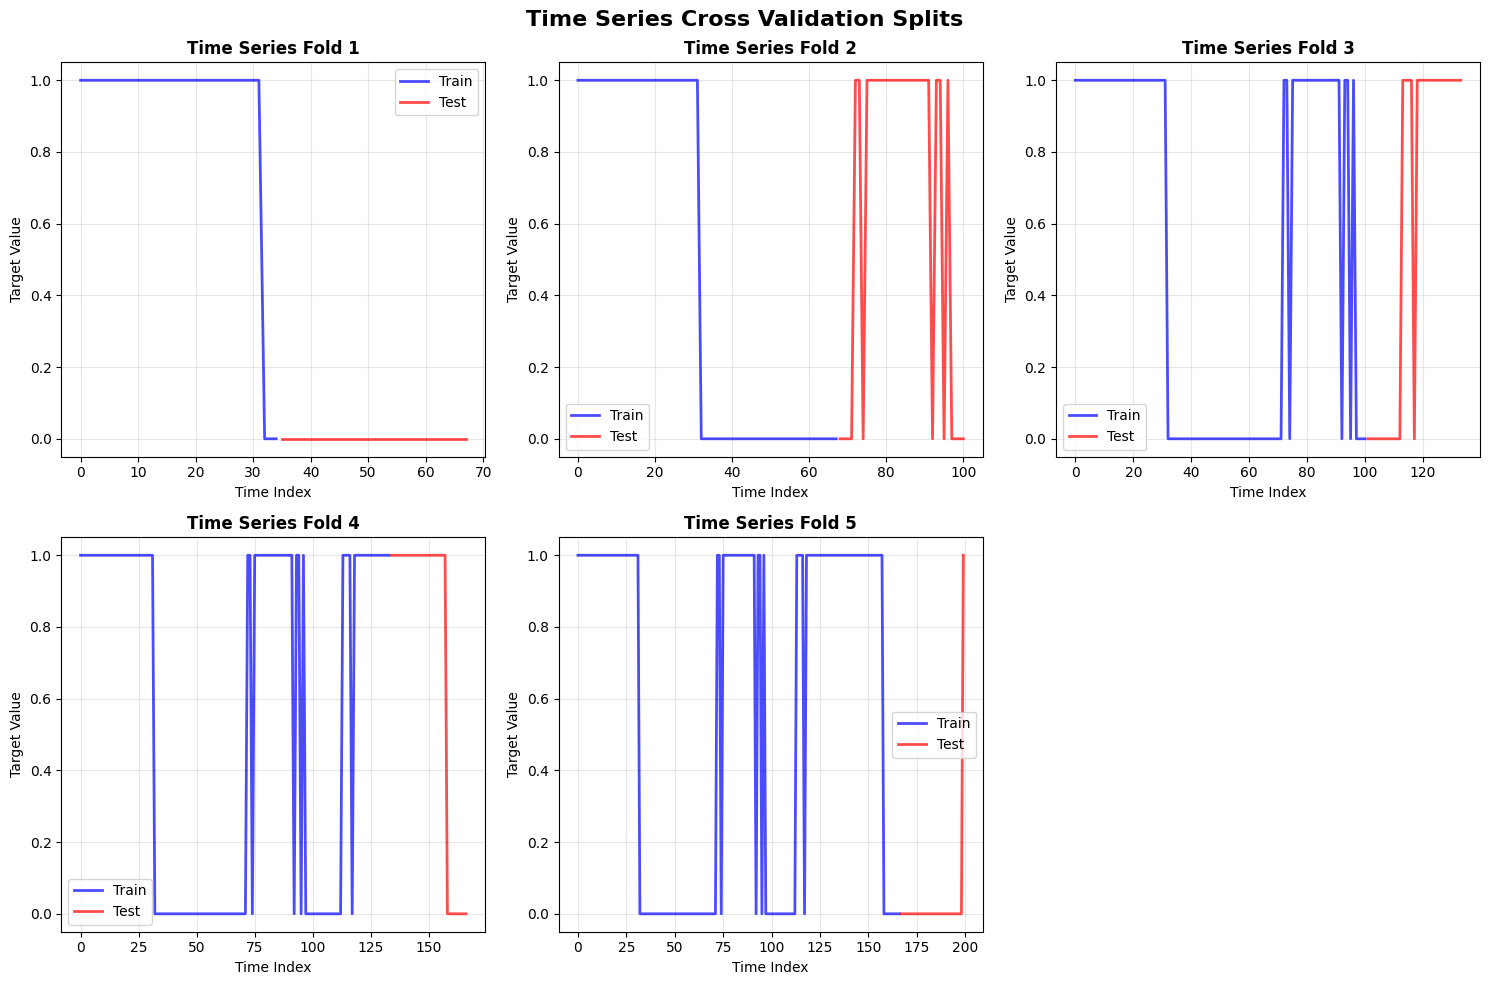

In [8]:
# Visualize the time series splits
plt.figure(figsize=(15, 10))
for i, (train_idx, test_idx) in enumerate(tscv.split(X_ts)):
    plt.subplot(2, 3, i+1)
    plt.plot(train_idx, y_ts[train_idx], 'b-', alpha=0.7, label='Train', linewidth=2)
    plt.plot(test_idx, y_ts[test_idx], 'r-', alpha=0.7, label='Test', linewidth=2)
    plt.title(f'Time Series Fold {i+1}', fontsize=12, fontweight='bold')
    plt.xlabel('Time Index')
    plt.ylabel('Target Value')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.suptitle('Time Series Cross Validation Splits', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

<a id='bootstrap'></a>
## 7. Bootstrap Validation

Random sampling with replacement - provides confidence intervals and estimates of sampling distribution.

In [9]:
def bootstrap_validation(X, y, n_iterations=100):
    """
    Bootstrap Validation
    Random sampling with replacement
    """
    print("BOOTSTRAP VALIDATION")
    print("="*50)
    
    model = RandomForestClassifier(n_estimators=50, random_state=RANDOM_STATE)
    
    # Shuffle Split (similar to bootstrap)
    shuffle_split = ShuffleSplit(n_splits=n_iterations, test_size=0.2, random_state=RANDOM_STATE)
    bootstrap_scores = cross_val_score(model, X, y, cv=shuffle_split, scoring='accuracy')
    
    print(f"Bootstrap Validation ({n_iterations} iterations):")
    print(f"Mean Bootstrap Score: {bootstrap_scores.mean():.4f}")
    print(f"Standard Deviation: {bootstrap_scores.std():.4f}")
    print(f"95% Confidence Interval: [{np.percentile(bootstrap_scores, 2.5):.4f}, {np.percentile(bootstrap_scores, 97.5):.4f}]")
    
    return bootstrap_scores

# Run Bootstrap validation
bootstrap_scores = bootstrap_validation(X_class, y_class)

BOOTSTRAP VALIDATION
Bootstrap Validation (100 iterations):
Mean Bootstrap Score: 0.9768
Standard Deviation: 0.0103
95% Confidence Interval: [0.9550, 0.9900]
Bootstrap Validation (100 iterations):
Mean Bootstrap Score: 0.9768
Standard Deviation: 0.0103
95% Confidence Interval: [0.9550, 0.9900]


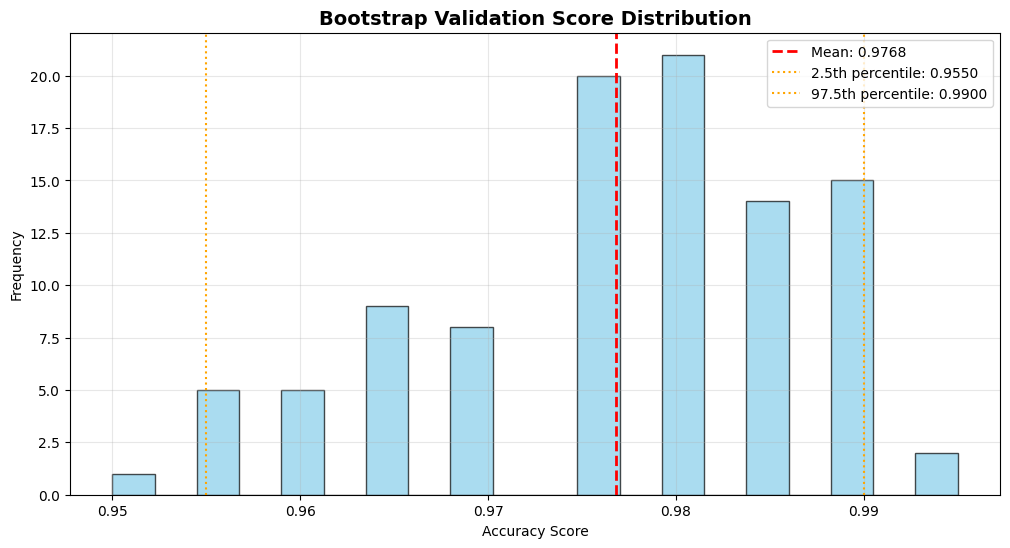

In [10]:
# Plot bootstrap distribution
plt.figure(figsize=(12, 6))
plt.hist(bootstrap_scores, bins=20, alpha=0.7, edgecolor='black', color='skyblue')
plt.axvline(bootstrap_scores.mean(), color='red', linestyle='--', linewidth=2, 
           label=f'Mean: {bootstrap_scores.mean():.4f}')
plt.axvline(np.percentile(bootstrap_scores, 2.5), color='orange', linestyle=':', 
           label=f'2.5th percentile: {np.percentile(bootstrap_scores, 2.5):.4f}')
plt.axvline(np.percentile(bootstrap_scores, 97.5), color='orange', linestyle=':', 
           label=f'97.5th percentile: {np.percentile(bootstrap_scores, 97.5):.4f}')
plt.xlabel('Accuracy Score')
plt.ylabel('Frequency')
plt.title('Bootstrap Validation Score Distribution', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

<a id='validation-curves'></a>
## 8. Validation Curves

Shows how model performance varies with hyperparameters - helps identify optimal parameter values.

In [11]:
def validation_curves_demo(X, y):
    """
    Validation Curves
    Shows how model performance varies with hyperparameters
    """
    print("VALIDATION CURVES")
    print("="*50)
    
    # Validation curve for RandomForest n_estimators
    param_range = [10, 25, 50, 75, 100, 150, 200]
    
    train_scores, val_scores = validation_curve(
        RandomForestClassifier(random_state=RANDOM_STATE),
        X, y, param_name='n_estimators', param_range=param_range,
        cv=5, scoring='accuracy', n_jobs=-1
    )
    
    # Calculate means and standard deviations
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)
    
    print(f"Best n_estimators: {param_range[np.argmax(val_mean)]}")
    print(f"Best validation score: {np.max(val_mean):.4f}")
    
    return train_scores, val_scores, param_range, train_mean, train_std, val_mean, val_std

# Run validation curves
train_scores, val_scores, param_range, train_mean, train_std, val_mean, val_std = validation_curves_demo(X_class, y_class)

VALIDATION CURVES
Best n_estimators: 150
Best validation score: 0.9820
Best n_estimators: 150
Best validation score: 0.9820


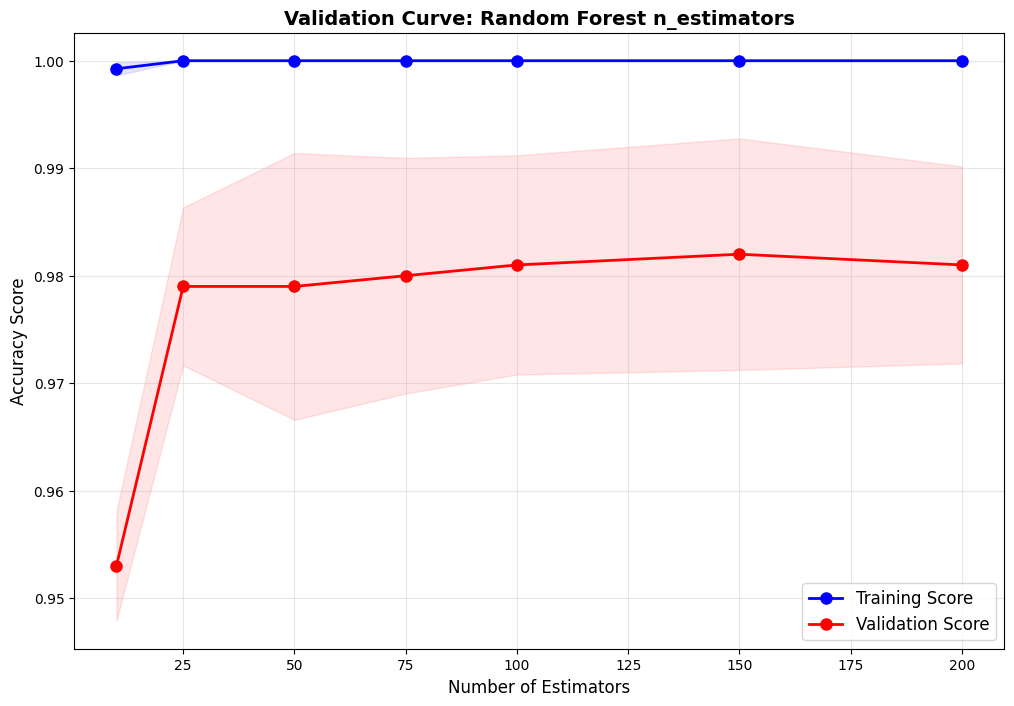

In [12]:
# Plot validation curve
plt.figure(figsize=(12, 8))
plt.plot(param_range, train_mean, 'o-', color='blue', label='Training Score', linewidth=2, markersize=8)
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, 
                 alpha=0.1, color='blue')

plt.plot(param_range, val_mean, 'o-', color='red', label='Validation Score', linewidth=2, markersize=8)
plt.fill_between(param_range, val_mean - val_std, val_mean + val_std, 
                 alpha=0.1, color='red')

plt.xlabel('Number of Estimators', fontsize=12)
plt.ylabel('Accuracy Score', fontsize=12)
plt.title('Validation Curve: Random Forest n_estimators', fontsize=14, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

<a id='learning-curves'></a>
## 9. Learning Curves

Shows how model performance varies with training set size - helps diagnose bias-variance tradeoff.

In [13]:
def learning_curves_demo(X, y):
    """
    Learning Curves
    Shows how model performance varies with training set size
    """
    print("LEARNING CURVES")
    print("="*50)
    
    # Learning curve
    train_sizes = np.linspace(0.1, 1.0, 10)
    
    train_sizes_abs, train_scores, val_scores = learning_curve(
        RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE),
        X, y, train_sizes=train_sizes, cv=5, scoring='accuracy', n_jobs=-1
    )
    
    # Calculate means and standard deviations
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)
    
    # Analyze learning curve
    final_gap = train_mean[-1] - val_mean[-1]
    print(f"Final training-validation gap: {final_gap:.4f}")
    
    if final_gap > 0.05:
        print("Model may be overfitting - consider regularization")
    elif val_mean[-1] < 0.8:
        print("Model may be underfitting - consider more complex model")
    else:
        print("Model appears to have good bias-variance tradeoff")
    
    return train_sizes_abs, train_scores, val_scores, train_mean, train_std, val_mean, val_std

# Run learning curves
train_sizes_abs, train_scores_lc, val_scores_lc, train_mean_lc, train_std_lc, val_mean_lc, val_std_lc = learning_curves_demo(X_class, y_class)

LEARNING CURVES
Final training-validation gap: 0.0190
Model appears to have good bias-variance tradeoff
Final training-validation gap: 0.0190
Model appears to have good bias-variance tradeoff


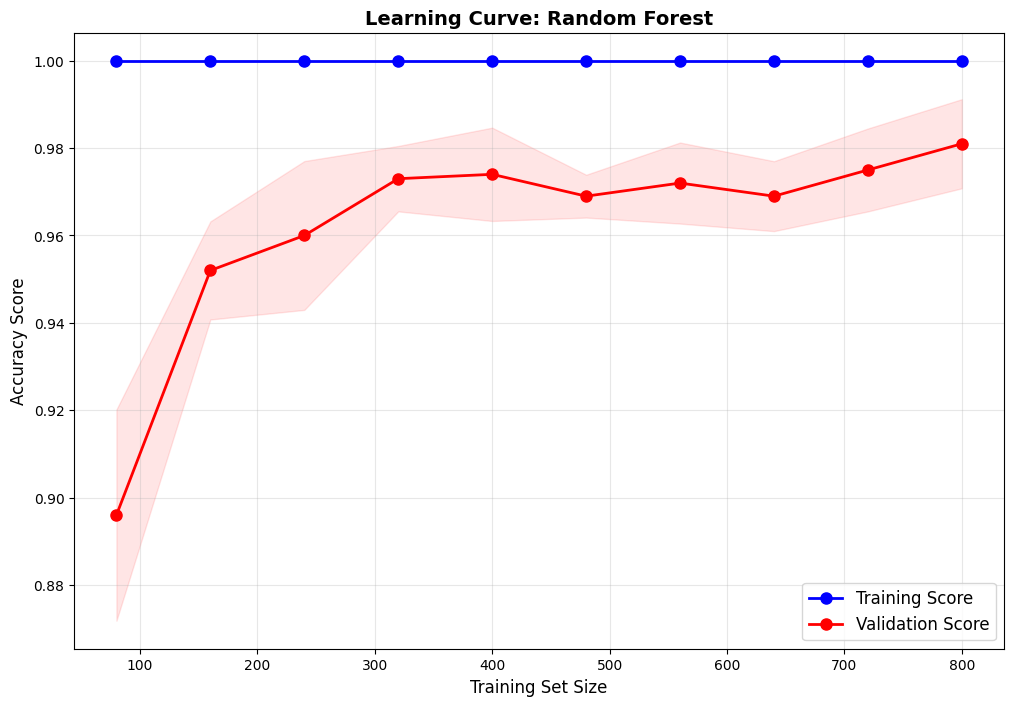

In [14]:
# Plot learning curve
plt.figure(figsize=(12, 8))
plt.plot(train_sizes_abs, train_mean_lc, 'o-', color='blue', label='Training Score', linewidth=2, markersize=8)
plt.fill_between(train_sizes_abs, train_mean_lc - train_std_lc, train_mean_lc + train_std_lc, 
                 alpha=0.1, color='blue')

plt.plot(train_sizes_abs, val_mean_lc, 'o-', color='red', label='Validation Score', linewidth=2, markersize=8)
plt.fill_between(train_sizes_abs, val_mean_lc - val_std_lc, val_mean_lc + val_std_lc, 
                 alpha=0.1, color='red')

plt.xlabel('Training Set Size', fontsize=12)
plt.ylabel('Accuracy Score', fontsize=12)
plt.title('Learning Curve: Random Forest', fontsize=14, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

<a id='hyperparameter'></a>
## 10. Hyperparameter Validation

Grid Search and Random Search for hyperparameter optimization with cross-validation.

In [15]:
def hyperparameter_validation(X, y):
    """
    Hyperparameter Validation with Grid Search and Random Search
    """
    print("HYPERPARAMETER VALIDATION")
    print("="*50)
    
    # Define parameter grid
    param_grid = {
        'n_estimators': [50, 100, 150],
        'max_depth': [3, 5, 7, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    
    print("Grid Search Cross Validation:")
    print(f"Parameter grid size: {np.prod([len(v) for v in param_grid.values()])} combinations")
    
    # Grid Search
    grid_search = GridSearchCV(
        RandomForestClassifier(random_state=RANDOM_STATE),
        param_grid, cv=3, scoring='accuracy', n_jobs=-1
    )
    
    # Use subset for faster demo
    X_subset, y_subset = X[:500], y[:500]
    grid_search.fit(X_subset, y_subset)
    
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_:.4f}")
    
    return grid_search

# Run hyperparameter validation
grid_search = hyperparameter_validation(X_class, y_class)

HYPERPARAMETER VALIDATION
Grid Search Cross Validation:
Parameter grid size: 108 combinations
Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
Best cross-validation score: 0.9720
Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
Best cross-validation score: 0.9720


In [16]:
# Random Search (more efficient for large parameter spaces)
print("\nRandom Search Cross Validation:")

# Expanded parameter space for random search
param_dist = {
    'n_estimators': [10, 50, 100, 150, 200],
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6],
    'max_features': ['sqrt', 'log2', None]
}

random_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=RANDOM_STATE),
    param_dist, n_iter=20, cv=3, scoring='accuracy', 
    n_jobs=-1, random_state=RANDOM_STATE
)

X_subset, y_subset = X_class[:500], y_class[:500]
random_search.fit(X_subset, y_subset)

print(f"Best parameters: {random_search.best_params_}")
print(f"Best cross-validation score: {random_search.best_score_:.4f}")


Random Search Cross Validation:
Best parameters: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None}
Best cross-validation score: 0.9680
Best parameters: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None}
Best cross-validation score: 0.9680


<a id='nested'></a>
## 11. Nested Cross Validation

Provides unbiased estimate of model performance with hyperparameter tuning - the gold standard for model evaluation.

In [17]:
def nested_cross_validation(X, y):
    """
    Nested Cross Validation
    Unbiased estimate of model performance with hyperparameter tuning
    """
    print("NESTED CROSS VALIDATION")
    print("="*50)
    
    # Outer loop for model evaluation
    outer_cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    
    # Inner loop for hyperparameter tuning
    inner_cv = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
    
    # Parameter grid
    param_grid = {
        'n_estimators': [50, 100],
        'max_depth': [3, 5, None],
        'min_samples_split': [2, 5]
    }
    
    nested_scores = []
    best_params_list = []
    
    for i, (train_idx, test_idx) in enumerate(outer_cv.split(X)):
        print(f"Outer fold {i+1}/5")
        
        X_train_outer, X_test_outer = X[train_idx], X[test_idx]
        y_train_outer, y_test_outer = y[train_idx], y[test_idx]
        
        # Inner cross-validation for hyperparameter tuning
        grid_search = GridSearchCV(
            RandomForestClassifier(random_state=RANDOM_STATE),
            param_grid, cv=inner_cv, scoring='accuracy'
        )
        
        grid_search.fit(X_train_outer, y_train_outer)
        
        # Evaluate best model on outer test fold
        best_model = grid_search.best_estimator_
        score = best_model.score(X_test_outer, y_test_outer)
        nested_scores.append(score)
        best_params_list.append(grid_search.best_params_)
        
        print(f"  Best params: {grid_search.best_params_}")
        print(f"  Test score: {score:.4f}")
    
    nested_scores = np.array(nested_scores)
    print(f"\nNested CV Results:")
    print(f"Individual fold scores: {nested_scores}")
    print(f"Mean nested CV score: {nested_scores.mean():.4f} (+/- {nested_scores.std() * 2:.4f})")
    print(f"This is an unbiased estimate of model performance!")
    
    return nested_scores, best_params_list

# Run nested cross validation
nested_scores, best_params_list = nested_cross_validation(X_class, y_class)

NESTED CROSS VALIDATION
Outer fold 1/5
  Best params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}
  Test score: 0.9800
Outer fold 2/5
  Best params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}
  Test score: 0.9800
Outer fold 2/5
  Best params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
  Test score: 0.9650
Outer fold 3/5
  Best params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
  Test score: 0.9650
Outer fold 3/5
  Best params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
  Test score: 0.9750
Outer fold 4/5
  Best params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
  Test score: 0.9750
Outer fold 4/5
  Best params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
  Test score: 0.9900
Outer fold 5/5
  Best params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
  Test score: 0.9900
Outer fold 5/5
  Best params: {'max_depth': None, 

<a id='comparison'></a>
## 12. Comparison of Validation Methods

Let's compare all the validation methods side by side to see their characteristics and performance estimates.

In [18]:
def compare_validation_methods(X, y):
    """
    Compare different validation methods
    """
    print("COMPARISON OF VALIDATION METHODS")
    print("="*50)
    
    model = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE)
    
    # Hold-out
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
    model.fit(X_train, y_train)
    holdout_score = model.score(X_test, y_test)
    
    # K-Fold CV
    kfold_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    
    # Stratified K-Fold CV
    stratified_scores = cross_val_score(model, X, y, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE), scoring='accuracy')
    
    # Bootstrap
    bootstrap_scores = cross_val_score(model, X, y, cv=ShuffleSplit(n_splits=50, test_size=0.2, random_state=RANDOM_STATE), scoring='accuracy')
    
    # Results comparison
    results = {
        'Hold-out': {'mean': holdout_score, 'std': 0},
        'K-Fold CV': {'mean': kfold_scores.mean(), 'std': kfold_scores.std()},
        'Stratified K-Fold': {'mean': stratified_scores.mean(), 'std': stratified_scores.std()},
        'Bootstrap': {'mean': bootstrap_scores.mean(), 'std': bootstrap_scores.std()}
    }
    
    print("Validation Method Comparison:")
    print("-" * 50)
    for method, scores in results.items():
        print(f"{method:20s}: {scores['mean']:.4f} (+/- {scores['std']:.4f})")
    
    return results

# Compare all methods
results = compare_validation_methods(X_class, y_class)

COMPARISON OF VALIDATION METHODS
Validation Method Comparison:
--------------------------------------------------
Hold-out            : 0.9800 (+/- 0.0000)
K-Fold CV           : 0.9810 (+/- 0.0102)
Stratified K-Fold   : 0.9730 (+/- 0.0129)
Bootstrap           : 0.9805 (+/- 0.0098)
Validation Method Comparison:
--------------------------------------------------
Hold-out            : 0.9800 (+/- 0.0000)
K-Fold CV           : 0.9810 (+/- 0.0102)
Stratified K-Fold   : 0.9730 (+/- 0.0129)
Bootstrap           : 0.9805 (+/- 0.0098)


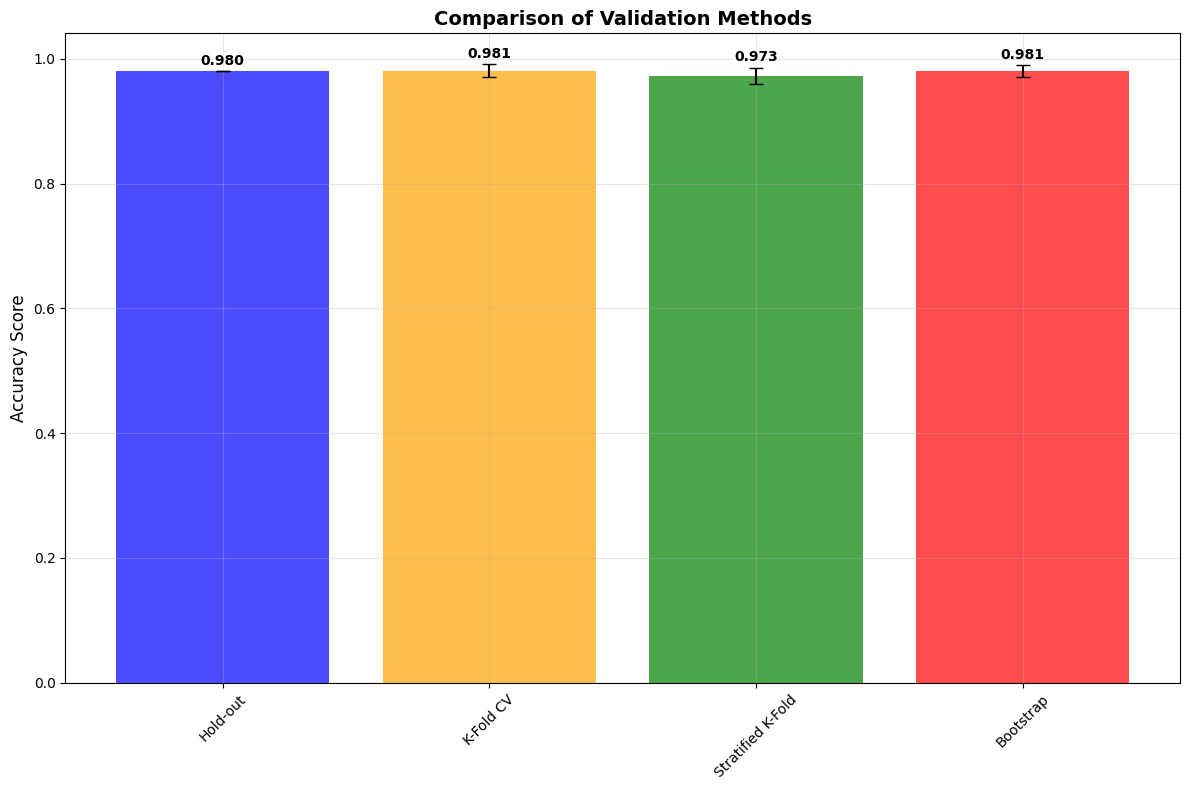

In [19]:
# Visualization of comparison
methods = list(results.keys())
means = [results[m]['mean'] for m in methods]
stds = [results[m]['std'] for m in methods]

plt.figure(figsize=(12, 8))
colors = ['blue', 'orange', 'green', 'red']
bars = plt.bar(methods, means, yerr=stds, capsize=5, alpha=0.7, color=colors)
plt.ylabel('Accuracy Score', fontsize=12)
plt.title('Comparison of Validation Methods', fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Add value labels on bars
for bar, mean, std in zip(bars, means, stds):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + std + 0.005,
            f'{mean:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## Summary and Key Takeaways

### When to Use Each Validation Method:

1. **Hold-out Validation**: Quick and simple, good for large datasets and initial model evaluation
2. **K-Fold CV**: Standard approach, good balance of computational cost and reliability
3. **Stratified K-Fold**: Best for classification with imbalanced classes
4. **LOOCV**: Maximum use of data, good for small datasets but computationally expensive
5. **Leave-P-Out**: Even more thorough than LOOCV but extremely expensive
6. **Time Series CV**: Essential for temporal data where future cannot predict past
7. **Bootstrap**: Provides confidence intervals and sampling distribution estimates
8. **Validation Curves**: Helps optimize individual hyperparameters
9. **Learning Curves**: Diagnoses bias-variance tradeoff and determines if more data helps
10. **Hyperparameter Validation**: Grid/Random search for parameter optimization
11. **Nested CV**: Gold standard for unbiased performance estimates with hyperparameter tuning

### Best Practices:

- Use **stratified k-fold** for classification with imbalanced classes
- Use **time series CV** for temporal data
- Use **nested CV** for unbiased performance estimates with hyperparameter tuning
- **Bootstrap** provides confidence intervals
- **Learning curves** help diagnose bias-variance tradeoff
- **Validation curves** help optimize hyperparameters
- Always use the same validation strategy consistently
- Consider computational cost vs. reliability tradeoffs

### Key Insights:

1. **No single validation method is perfect** - choose based on your specific use case
2. **Cross-validation provides more robust estimates** than simple hold-out
3. **Nested CV is essential** when comparing different algorithms fairly
4. **Learning and validation curves** provide insights beyond just performance scores
5. **Time series data requires special handling** to avoid data leakage